In [1]:
import sys
sys.path.insert(0, '/Users/david/galvanize/super_liga_xg')

In [2]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scraping_tools.html_scraper import db
from data_preparation import ConvertData

In [4]:
pd.set_option('display.max_columns', 50)

# 1) Pulling shot data from mongo_db and preparing for modeling


 - **games** - game data scraped from afa
 
 - use the ConvertData class to remove penalty kicks and create a dataframe with angle and distance

In [5]:
games = db['games_update'].find()

In [6]:
cd = ConvertData()

In [7]:
df = cd.games_to_df(games)

In [8]:
df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1.0,0.0,1
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0.0,0.0,0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,20,26.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0.0,1.0,1
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1.0,0.0,0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0.0,0.0,0


In [9]:
df_no_pen = cd.drop_penalties(df)

In [10]:
df_no_pen['is_penalty_attempt'].unique()

array([0.])

In [11]:
df_no_pen.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1.0,0.0,1
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0.0,0.0,0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1.0,0.0,0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0.0,0.0,0
5,448548,77892.0,11.56,0.44,10.59,-1.21,-1,0.14,22336802,35,13,44.483333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.677426,42.492487,0.0,0.0,0


In [12]:
X, y, shot_df = cd.create_xy_prep(df_no_pen)

In [13]:
len(X) == len(y)

True

In [14]:
shot_df.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_goal,passed_from_id
0,99779.0,6.838786,12.755990,1.0,1,177285.0
1,60730.0,21.747333,11.242763,0.0,0,NaN
3,185745.0,16.803407,59.849102,1.0,0,177285.0
4,77892.0,26.220122,32.065607,0.0,0,NaN
5,77892.0,15.677426,42.492487,0.0,0,NaN


# 2) Performance w K-folds

- testing models with k-folds using class **KfoldComparison**

In [15]:
from kfold_comp import KfoldComparison
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import numpy as np

In [16]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=3, verbose=1, random_state=8)
xgb_model = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 300, random_state=8)
gb_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='log2', min_samples_leaf=4, n_estimators=280, subsample=0.25, random_state=8)

In [17]:
kc = KfoldComparison(rf_model, xgb_model, gb_model)

In [18]:
model_performance = kc.kfold_performance(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [19]:
model_performance

{'RandomForestClassifier': {'scores over k splits': [0.3265309913151358,
   0.29455572527567503,
   0.3287689808310976,
   0.2533063048496822,
   0.28185463056138704],
  'mean score': 0.29700332656659556},
 'XGBClassifier': {'scores over k splits': [0.30789044373394814,
   0.2941813835655065,
   0.3085672311484814,
   0.2947128208134981,
   0.2740278569583689],
  'mean score': 0.2958759472439606},
 'GradientBoostingClassifier': {'scores over k splits': [0.25074771735376367,
   0.3198077630053424,
   0.2688710279242044,
   0.3079859965598088,
   0.33257874510255114],
  'mean score': 0.2959982499891341}}

# 3) Tuning

- tuning models with classes **XGBoostTuner** and **GradientBoostTuner**
which return the best parameters

- **XGBoostTuner** mostly tries to find the optimum number of trees to use

- **GradientBoostTuner** tries to find optimum depth and trees

In [20]:
from kfold_comp import XGBoostTuner

In [21]:
xt = XGBoostTuner()

In [22]:
xgb_scores = xt.xgb_kfolds(X, y, [2, 4, 6, 8, 10])

In [23]:
xgb_scores

{'200 trees': {'scores over k splits': [0.2816721017308095,
   0.32740437424577334,
   0.32946528785807244,
   0.30418625906767216,
   0.310379210480973],
  'mean score': 0.31062144667666003},
 '400 trees': {'scores over k splits': [0.25815887538551846,
   0.31372768909067794,
   0.32673792123301504,
   0.2836558890693328,
   0.2918054312357846],
  'mean score': 0.2948171612028657},
 '600 trees': {'scores over k splits': [0.25803475937093884,
   0.31612348025527726,
   0.3338475966524771,
   0.28394035650280247,
   0.29154427903423163],
  'mean score': 0.29669809436314554},
 '800 trees': {'scores over k splits': [0.25906854669618257,
   0.31798471049063237,
   0.33801172424710413,
   0.2868350292158806,
   0.29153451789170504],
  'mean score': 0.2986869057083009},
 '1000 trees': {'scores over k splits': [0.26156619181993473,
   0.31978976792820235,
   0.3410332368734731,
   0.28749561519225075,
   0.2929445285355571],
  'mean score': 0.30056586806988356}}

In [24]:
xt.best_params()

(0.2948171612028657, '400 trees')

In [25]:
from kfold_comp import GradientBoostTuner

In [26]:
gbt = GradientBoostTuner()

In [27]:
gb_dict = gbt.gb_kfolds(X, y)

In [28]:
gb_dict

{'Depth 1': {'scores over ksplits': [0.3278896841854008,
   0.2771198769558616,
   0.2547523516554557,
   0.3344300790899741,
   0.27002035608711744],
  'mean score': 0.29284246959476196,
  'number of trees': [251, 299, 298, 299, 299]},
 'Depth 2': {'scores over ksplits': [0.3298497351695275,
   0.2769082890698536,
   0.25573471630754313,
   0.33226660199883834,
   0.2702319854615492],
  'mean score': 0.29299826560146236,
  'number of trees': [145, 297, 226, 130, 299]},
 'Depth 3': {'scores over ksplits': [0.33283578462514835,
   0.27651759676562976,
   0.2570853913283739,
   0.3314182649533366,
   0.26804997621466037],
  'mean score': 0.2931814027774298,
  'number of trees': [164, 284, 243, 114, 283]},
 'Depth 4': {'scores over ksplits': [0.340399598522045,
   0.28258202329443755,
   0.2588682562043538,
   0.33268057543983426,
   0.2694788586179748],
  'mean score': 0.2968018624157291,
  'number of trees': [92, 143, 143, 128, 292]},
 'Depth 5': {'scores over ksplits': [0.3436750639504

In [29]:
gbt.best_params()

('Depth 1', 0.29284246959476196, 289.2)

# 4) Comparing Tuned Models

In [30]:
xgboost_model = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 400, random_state=8)
gradient_boost_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='log2', min_samples_leaf=4, n_estimators=289, subsample=0.25, random_state=8)
random_forest_model = RandomForestClassifier(n_estimators=300, max_depth=3, verbose=1, random_state=8)

In [31]:
kc_tuned = KfoldComparison(random_forest_model, xgboost_model, gradient_boost_model)

In [32]:
tuned_model_performance = kc_tuned.kfold_performance(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [33]:
tuned_model_performance

{'RandomForestClassifier': {'scores over k splits': [0.3017122658247405,
   0.30352122182982066,
   0.2923297502164155,
   0.28746720939513376,
   0.2959599367267722],
  'mean score': 0.2961980767985765},
 'XGBClassifier': {'scores over k splits': [0.3018565762541531,
   0.29439978854840293,
   0.2985634354819708,
   0.2844853994820048,
   0.29282833134346753],
  'mean score': 0.2944267062219998},
 'GradientBoostingClassifier': {'scores over k splits': [0.34815944244230856,
   0.30829254292380126,
   0.2682533270748996,
   0.28660867964527253,
   0.28694071450160324],
  'mean score': 0.299650941317577}}

In [34]:
model_performance

{'RandomForestClassifier': {'scores over k splits': [0.3265309913151358,
   0.29455572527567503,
   0.3287689808310976,
   0.2533063048496822,
   0.28185463056138704],
  'mean score': 0.29700332656659556},
 'XGBClassifier': {'scores over k splits': [0.30789044373394814,
   0.2941813835655065,
   0.3085672311484814,
   0.2947128208134981,
   0.2740278569583689],
  'mean score': 0.2958759472439606},
 'GradientBoostingClassifier': {'scores over k splits': [0.25074771735376367,
   0.3198077630053424,
   0.2688710279242044,
   0.3079859965598088,
   0.33257874510255114],
  'mean score': 0.2959982499891341}}

2/3 tuned_model_performance perform better - xgboost is the best

# Modeling on all

- call on **ExpectedGoal** class to predict_prob of every shot

- 

In [35]:
from xg import ExpectedGoal

In [36]:
shot_df.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_goal,passed_from_id
0,99779.0,6.838786,12.755990,1.0,1,177285.0
1,60730.0,21.747333,11.242763,0.0,0,NaN
3,185745.0,16.803407,59.849102,1.0,0,177285.0
4,77892.0,26.220122,32.065607,0.0,0,NaN
5,77892.0,15.677426,42.492487,0.0,0,NaN


In [37]:
eg = ExpectedGoal(random_forest_model, xgboost_model, gradient_boost_model, shot_df)

In [38]:
eg.predict_prob()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
/Users/david/galvanize/super_liga_xg/src/xg.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df['xG'] = p_ensemble[:, 1]


In [39]:
total_df = eg.xg_and_xa()

In [40]:
total_df.head()

,player_id,total_xG,goals,total_xA,total_xG+xA
125,24256.0,5.60,12,0.50,6.10
113,488.0,3.18,8,0.37,3.55
234,119431.0,1.89,6,1.69,3.58
83,136659.0,1.94,5,0.51,2.45
344,172801.0,2.12,5,0.26,2.38


In [41]:
total_df['total_xG'].sum()

350.34000000000003

In [42]:
total_df['goals'].sum()

342

In [43]:
shot_df.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_goal,passed_from_id,xG
0,99779.0,6.838786,12.755990,1.0,1,177285.0,0.366035
1,60730.0,21.747333,11.242763,0.0,0,NaN,0.059913
3,185745.0,16.803407,59.849102,1.0,0,177285.0,0.075599
4,77892.0,26.220122,32.065607,0.0,0,NaN,0.048718
5,77892.0,15.677426,42.492487,0.0,0,NaN,0.080342


In [44]:
df_no_pen = eg.transform_coordinate_xg(df_no_pen)

In [45]:
df_no_pen.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal,xG
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1.0,0.0,1,0.366035
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0.0,0.0,0,0.059913
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1.0,0.0,0,0.075599
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0.0,0.0,0,0.048718
5,448548,77892.0,11.56,0.44,10.59,-1.21,-1,0.14,22336802,35,13,44.483333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.677426,42.492487,0.0,0.0,0,0.080342


# Player Data

- use the class **PlayerDataFrameCreator** to create dataframe of all players + relevant info + minutes

In [46]:
from player_cleaner import PlayerDataframeCreator

In [47]:
players = db.players.find()
games = db['games_update'].find()

In [48]:
pdc = PlayerDataframeCreator(games, players)

In [49]:
player_df = pdc.create_player_df()

In [50]:
player_df.head()

,minutes_played,name,player_id,squad_num,team_id,position,birthday,club,foot,height,age,transfer_value(USD)
0,1080.000000,Alexander Domínguez,19132.0,22.0,20,Goalie,"Jun 5, 1987 (31)",Squad Club Atlético Vélez Sarsfield,right,"1,95 m",31,2.01
1,180.000000,Lucas Hoyos,27987.0,12.0,20,Goalie,"Apr 29, 1989 (29)",Squad Club Atlético Vélez Sarsfield,right,"1,83 m",29,0.17
2,986.483333,Gastón Díaz,30896.0,24.0,20,Defender,"Mar 13, 1988 (30)",Squad Club Atlético Vélez Sarsfield,right,"1,75 m",30,0.57
3,1080.000000,Joaquín Laso,94225.0,6.0,20,Defender,"Jul 4, 1990 (28)",Squad Club Atlético Vélez Sarsfield,right,"1,85 m",28,0.34
4,1170.000000,Luis Abram,99779.0,29.0,20,Defender,"Feb 27, 1996 (22)",Squad Club Atlético Vélez Sarsfield,left,"1,80 m",22,0.51


# Merging

combine the dataframe **total_df** (df with player id and xg stats) with **player_df** which 
has player metadata

In [51]:
from player_cleaner import FinalDataframe

In [52]:
fd = FinalDataframe(player_df, total_df)

In [53]:
final_df = fd.final_df_creator()

In [54]:
final_df.head()

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA
352,24256.0,Emmanuel Gigliotti,Forward,1247.966667,31,3.43,12,5.60,0.50,6.10
336,488.0,Lisandro López,Forward,1118.533333,35,2.01,8,3.18,0.37,3.55
417,119431.0,Matías Rojas,Midfielder,875.516667,23,0.34,6,1.89,1.69,3.58
125,98292.0,Facundo Barceló,Forward,688.916667,25,0.57,5,2.63,0.26,2.89
199,172801.0,Nahuel Bustos,Forward,857.900000,20,0.06,5,2.12,0.26,2.38


In [55]:
stats_df = fd.additional_stats()

In [56]:
stats_df.head()

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA,xG+xA/90,Goals v. Expected Diff
352,24256.0,Emmanuel Gigliotti,Forward,1247.966667,31,3.43,12,5.60,0.50,6.10,0.44,6.40
336,488.0,Lisandro López,Forward,1118.533333,35,2.01,8,3.18,0.37,3.55,0.29,4.82
417,119431.0,Matías Rojas,Midfielder,875.516667,23,0.34,6,1.89,1.69,3.58,0.37,4.11
125,98292.0,Facundo Barceló,Forward,688.916667,25,0.57,5,2.63,0.26,2.89,0.38,2.37
199,172801.0,Nahuel Bustos,Forward,857.900000,20,0.06,5,2.12,0.26,2.38,0.25,2.88


# Player Querying

In [57]:
#top 20 scorers
top_20_scorers = stats_df.head(20).copy()

In [58]:
top_20_xg = stats_df.sort_values('total_xG', ascending=False).head(20).copy()

In [84]:
top_20_scorers

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA,xG+xA/90,Goals v. Expected Diff
352,24256.0,Emmanuel Gigliotti,Forward,1247.966667,31,3.43,12,5.60,0.50,6.10,0.44,6.40
336,488.0,Lisandro López,Forward,1118.533333,35,2.01,8,3.18,0.37,3.55,0.29,4.82
417,119431.0,Matías Rojas,Midfielder,875.516667,23,0.34,6,1.89,1.69,3.58,0.37,4.11
125,98292.0,Facundo Barceló,Forward,688.916667,25,0.57,5,2.63,0.26,2.89,0.38,2.37
199,172801.0,Nahuel Bustos,Forward,857.900000,20,0.06,5,2.12,0.26,2.38,0.25,2.88
211,136659.0,Ángel González,Forward,913.783333,24,2.86,5,1.94,0.51,2.45,0.24,3.06
323,16081.0,Luis Rodríguez,Forward,917.900000,33,1.71,4,2.77,0.75,3.52,0.35,1.23
110,30266.0,Cristian Chávez,Forward,1088.266667,31,0.57,4,2.60,0.58,3.18,0.26,1.40
135,121814.0,Leonardo Heredia,Midfielder,845.866667,22,0.06,4,1.16,0.16,1.32,0.14,2.84
292,39578.0,Lucas Gamba,Forward,915.416667,31,2.01,4,1.30,0.69,1.99,0.20,2.70


In [60]:
top_20_xg.head()

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA,xG+xA/90,Goals v. Expected Diff
352,24256.0,Emmanuel Gigliotti,Forward,1247.966667,31,3.43,12,5.60,0.50,6.10,0.44,6.40
240,20195.0,Sebastián Ribas,Forward,1166.283333,30,1.71,4,3.95,0.21,4.16,0.32,0.05
337,17217.0,Jonatan Cristaldo,Forward,944.966667,29,1.37,3,3.89,0.39,4.28,0.41,-0.89
97,93853.0,Franco Soldano,Forward,1240.350000,24,5.71,2,3.72,0.40,4.12,0.30,-1.72
212,31939.0,Santiago García,Forward,1159.566667,28,6.86,4,3.48,0.37,3.85,0.30,0.52


In [61]:
top_20_contributions = stats_df.sort_values('total_xG+xA', ascending=False).head(20).copy()

In [62]:
top_20_contributions.head()

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA,xG+xA/90,Goals v. Expected Diff
352,24256.0,Emmanuel Gigliotti,Forward,1247.966667,31,3.43,12,5.60,0.50,6.10,0.44,6.40
333,81286.0,Guillermo Fernández,Midfielder,1035.433333,27,4.57,3,1.82,3.11,4.93,0.43,1.18
24,36681.0,Víctor Figueroa,Midfielder,794.483333,35,0.23,0,2.02,2.51,4.53,0.51,-2.02
5,185745.0,Lucas Robertone,Midfielder,965.516667,21,3.43,3,2.50,1.84,4.34,0.40,0.50
337,17217.0,Jonatan Cristaldo,Forward,944.966667,29,1.37,3,3.89,0.39,4.28,0.41,-0.89


In [63]:
stats_df[stats_df['name'] == 'Gonzalo Martínez']

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA,xG+xA/90,Goals v. Expected Diff
303,77919.0,Gonzalo Martínez,Midfielder,321.7,25,17.14,1,0.5,0.0,0.5,0.14,0.5


In [86]:
top_20_per90 = stats_df[(stats_df['minutes_played'] > 500) & (stats_df['age'] < 26)].sort_values('xG+xA/90', ascending=False).head(20).copy()

In [87]:
top_20_per90

,player_id,name,position,minutes_played,age,transfer_value(USD),goals,total_xG,total_xA,total_xG+xA,xG+xA/90,Goals v. Expected Diff
170,118855.0,Nazareno Solís,Forward,597.050000,24,0.69,1,1.40,2.22,3.62,0.55,-0.40
5,185745.0,Lucas Robertone,Midfielder,965.516667,21,3.43,3,2.50,1.84,4.34,0.40,0.50
320,103537.0,David Barbona,Midfielder,624.300000,23,2.29,2,1.68,1.02,2.70,0.39,0.32
79,189736.0,Alexis Mac Allister,Midfielder,533.833333,19,4.57,2,1.34,0.90,2.24,0.38,0.66
125,98292.0,Facundo Barceló,Forward,688.916667,25,0.57,5,2.63,0.26,2.89,0.38,2.37
417,119431.0,Matías Rojas,Midfielder,875.516667,23,0.34,6,1.89,1.69,3.58,0.37,4.11
180,43746.0,Edwin Cardona,Midfielder,676.033333,25,6.29,2,1.11,1.49,2.60,0.35,0.89
54,172565.0,Nicolás Reniero,Forward,1057.333333,23,2.29,3,2.98,0.83,3.81,0.32,0.02
84,209887.0,Gastón Verón,Forward,577.350000,17,NaN,1,1.83,0.18,2.01,0.31,-0.83
97,93853.0,Franco Soldano,Forward,1240.350000,24,5.71,2,3.72,0.40,4.12,0.30,-1.72


In [66]:
from analysis import individual_shot_map, plot_goals_map

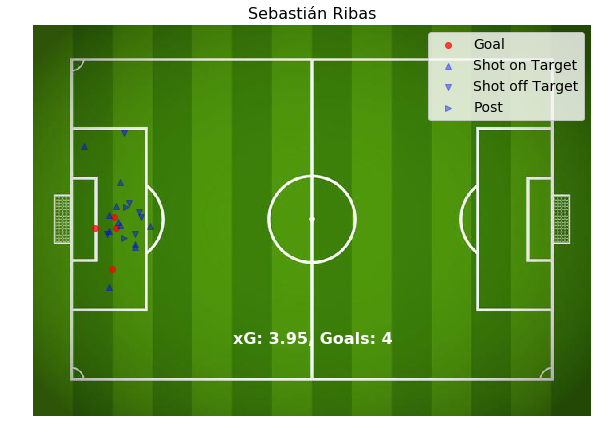

In [67]:
individual_shot_map(df_no_pen, final_df, 20195.0)

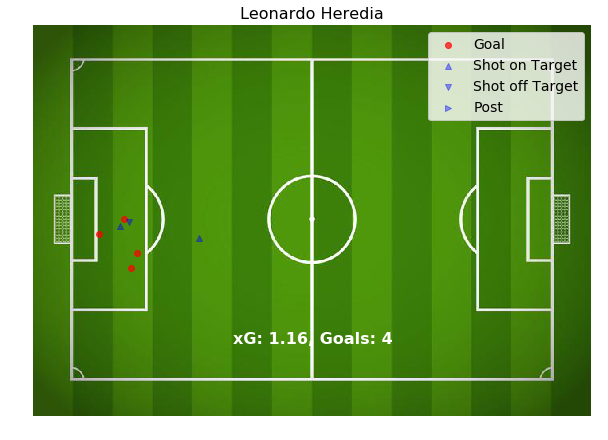

In [68]:
individual_shot_map(df_no_pen, final_df, 121814.0)

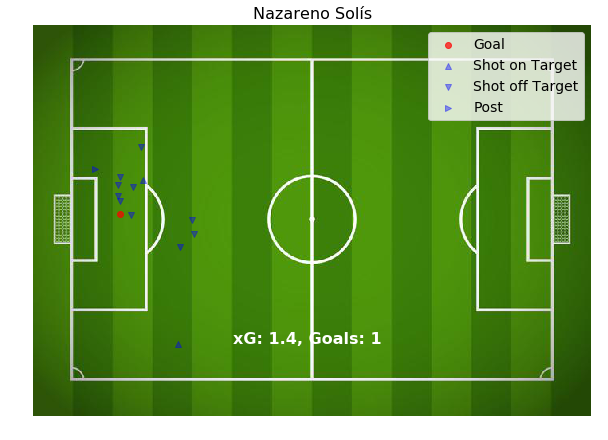

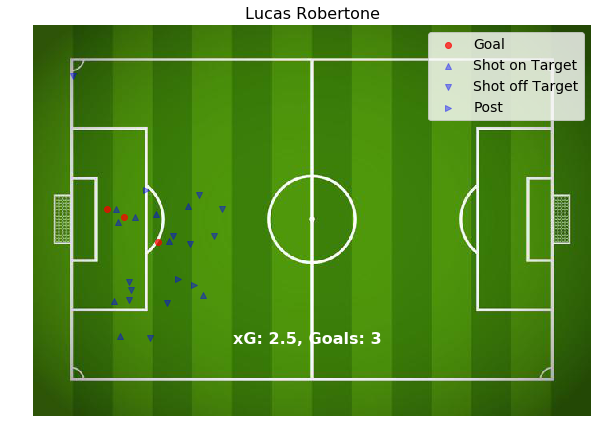

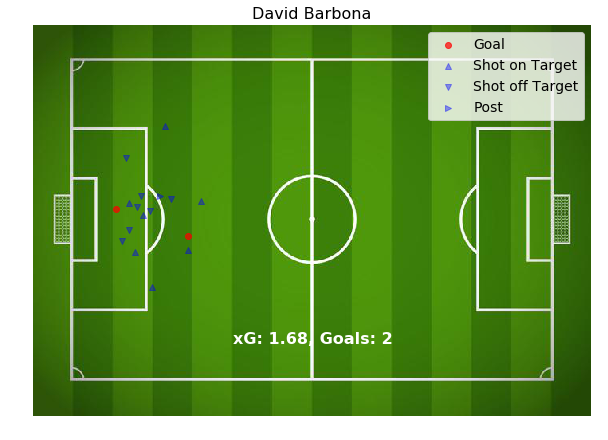

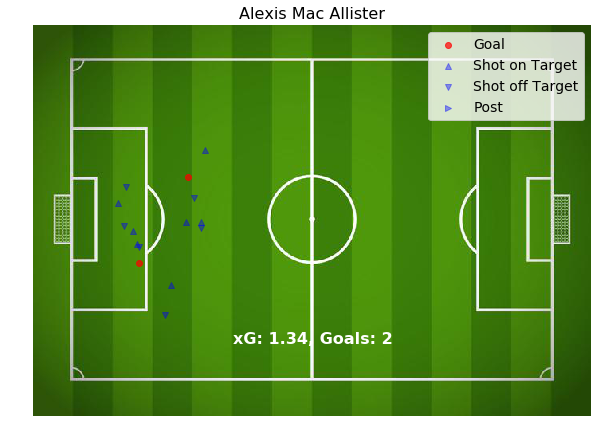

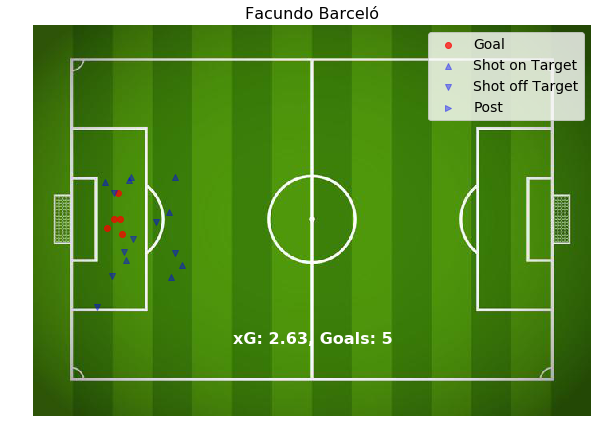

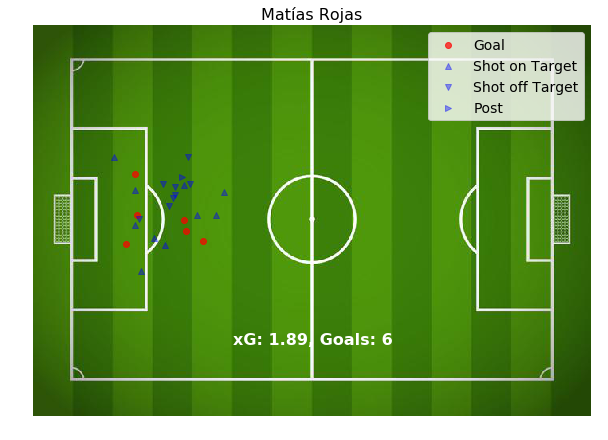

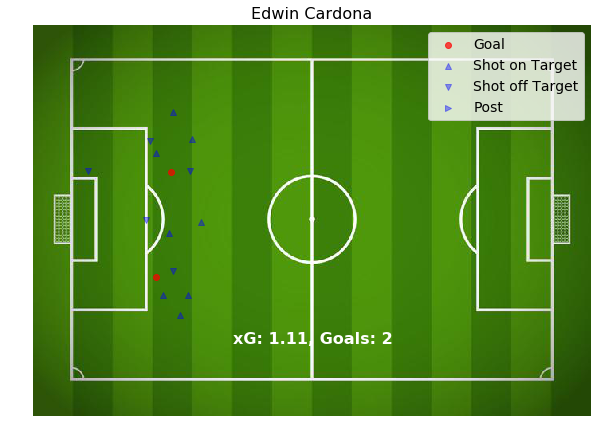

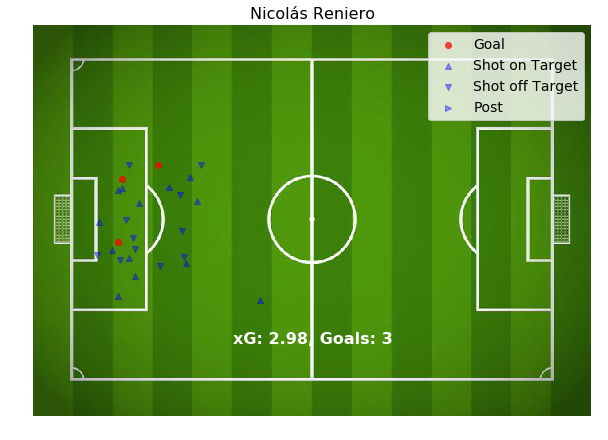

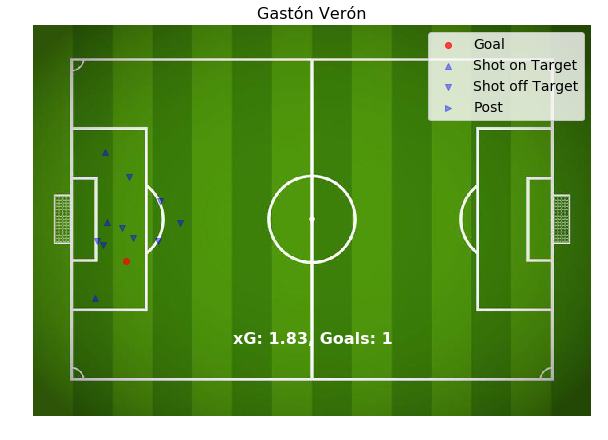

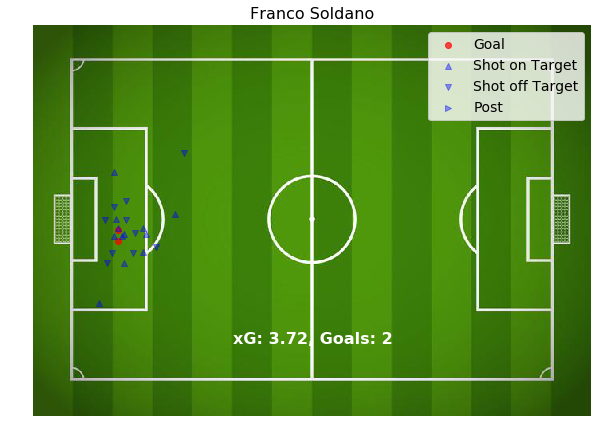

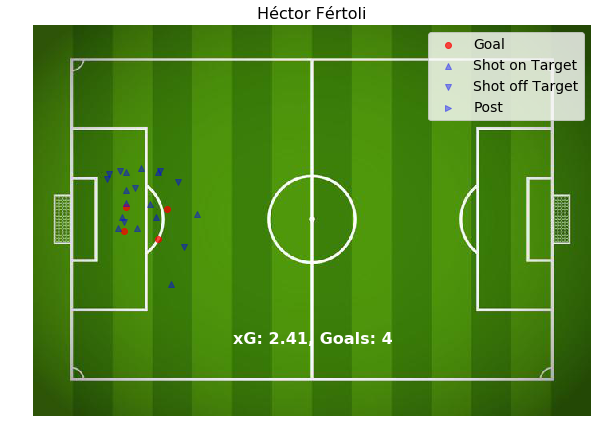

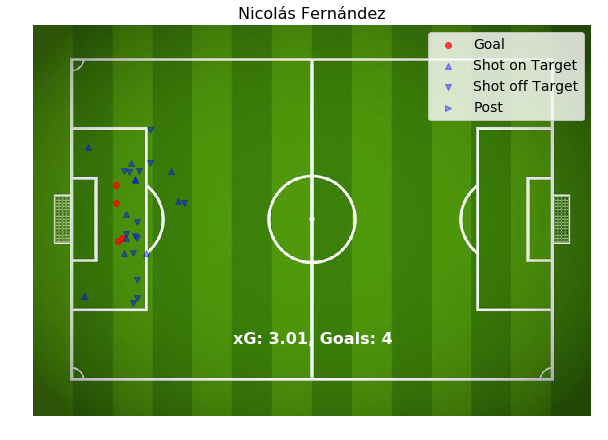

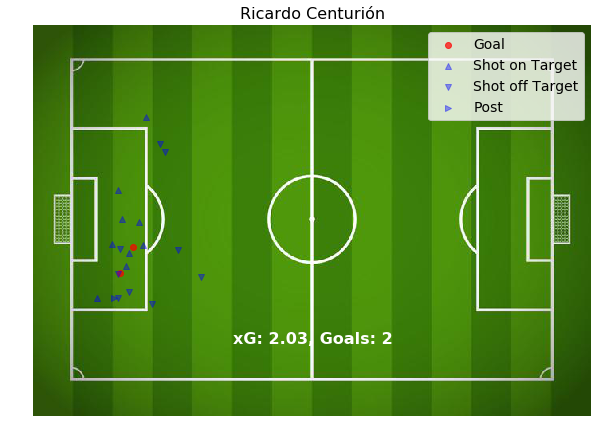

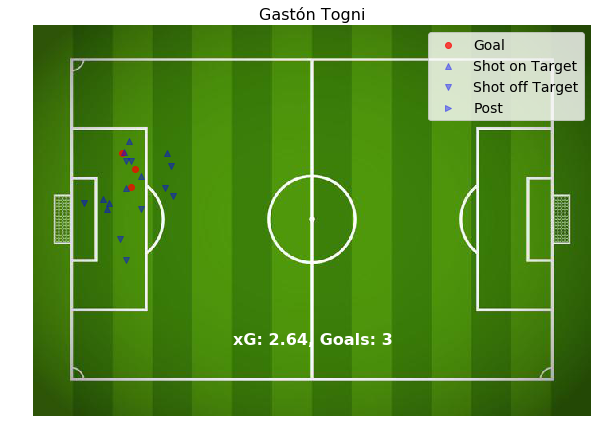

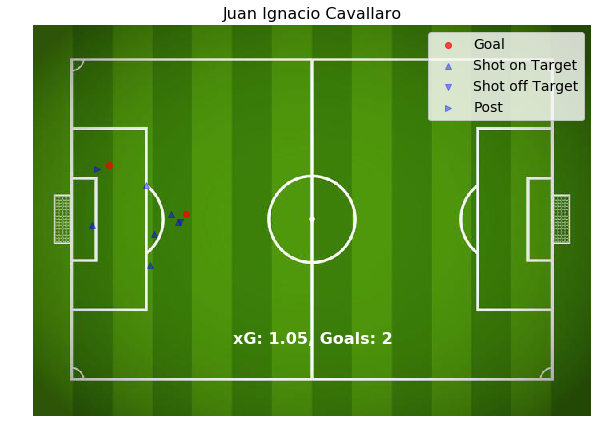

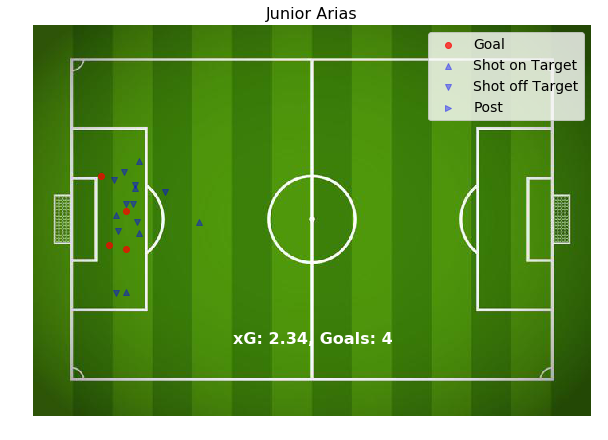

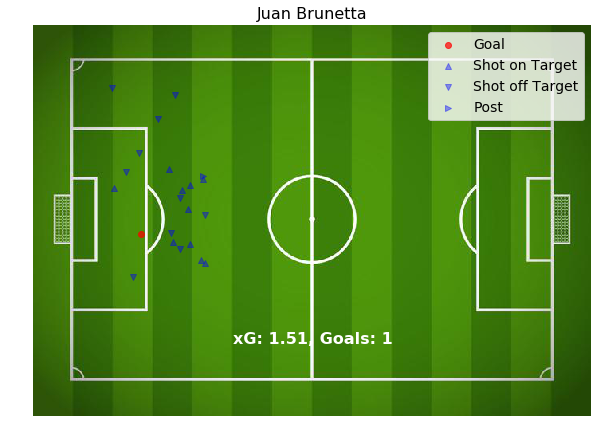

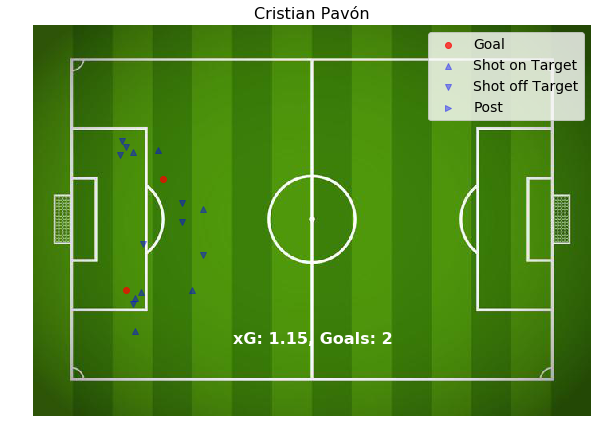

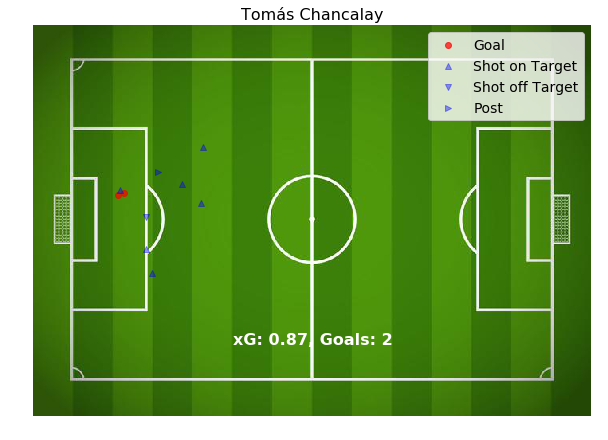

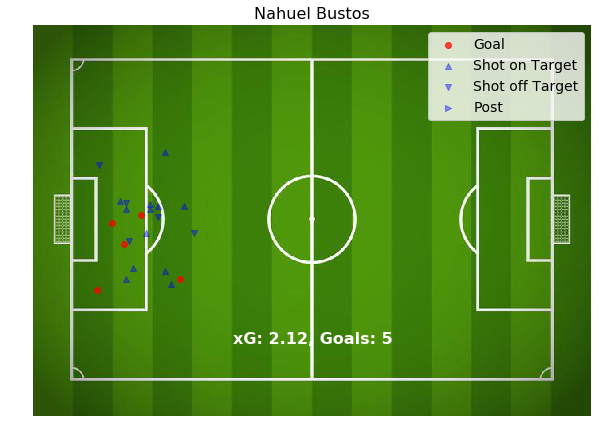

In [91]:
for player_id in list(top_20_per90['player_id']):
    individual_shot_map(df_no_pen, final_df, player_id)

In [69]:
lowest_goal_prob = df_no_pen[(df_no_pen['is_goal'] == 1)].sort_values('xG').head(20)

In [70]:
lowest_goal_prob['xG'].mean()

0.060493822901522054

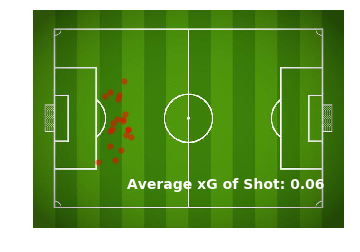

In [71]:
plot_goals_map(lowest_goal_prob, 0.060 )

In [72]:
highest_goal_prob = df_no_pen[(df_no_pen['is_goal'] == 1)].sort_values('xG', ascending=False).head(20)

In [73]:
highest_goal_prob['xG'].mean()

0.4065491507442098

plot_goals_map(highest_goal_prob, 0.41 )

# Takeaways:

When only accounting for shots that are not penalty kick attempts:

- actual goals scored: 342 vs. number of predicted goals: 350

- highest probability it will award a shot is ~.40. that seems low

- half the players in the top 20 of goals are also in the top 20 of xG

## Limitations:

- unable to filter out header/weak foot/free kick attempts 

In [80]:
top_20_name = set(top_20_scorers.name)
top_20_xg_name = set(top_20_xg.name)

In [82]:
list(set.intersection(top_20_name, top_20_xg_name))

['Facundo Barceló',
 'Emmanuel Gigliotti',
 'Sebastián Ribas',
 'Nicolás Fernández',
 'Fernando Zampedri',
 'Santiago García',
 'Cristian Chávez',
 'Lisandro López',
 'Luis Rodríguez',
 'Héctor Fértoli']

# Next Steps:

- see how model predicts the rest of the season

- add a position or player variable to model